In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

In [2]:
class CustomDataset(Dataset):
    def __init__(self, annotations_file, min_labels, max_labels, min_target, max_target, transform=None, train=True):
        if train:
            self.data = pd.read_csv(annotations_file).iloc[0:35000]
        else:
            self.data = pd.read_csv(annotations_file).iloc[35000:]
        
        self.transform = transform
        self.min_labels = min_labels
        self.max_labels = max_labels
        self.min_target = min_target
        self.max_target = max_target

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        target = self.data["RMSD"].iloc[idx]
        labels = self.data.iloc[idx, 1:9].values.astype("float32")
        labels = torch.from_numpy(labels)
        target = torch.tensor(target, dtype=torch.float32)
        labels = (labels - self.min_labels) / (self.max_labels - self.min_labels + 1e-8)
        target = (target - self.min_target) / (self.max_target - self.min_target + 1e-8)
        if self.transform:
            labels = self.transform(labels)
        return labels, target



In [3]:
class FiveLayerNet(nn.Module):
    def __init__(self, layer1, layer2, layer3, layer4, layer5, activation=nn.LeakyReLU(0.2)):
        super(FiveLayerNet, self).__init__()
        self.net = nn.Sequential(
            layer1,
            activation,
            layer2,
            activation,
            layer3,
            activation,
            layer4,
            activation,
            layer5,
            activation
        )

    def forward(self, x):
        return self.net(x)

In [4]:
class Autoencoder(nn.Module):
    def __init__(self, layer_in, layer_out, activation=nn.ReLU()):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            layer_in,
            activation
        )
        self.decoder = nn.Sequential(
            layer_out,
            activation,
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

In [5]:
def train(model, device, train_loader, epochs=20, lr=0.01):
    loss_fn = nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.99), eps=1e-08, weight_decay=1e-5)
    history = []

    for epoch in tqdm(range(epochs)):
        epoch_loss = 0.0
        for batch, labels in train_loader:
            optimizer.zero_grad()

            batch = batch.float()
            batch, labels = batch.to(device), labels.to(device)

            outputs = model(batch)
            labels = labels.unsqueeze(1)

            loss = loss_fn(outputs, labels)
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()

        average_loss = epoch_loss / len(train_loader)
        history.append(average_loss)
        print(f'Epoch {epoch + 1}, Loss: {average_loss:.4f}')

    return history

In [6]:
def test(model, device, test_loader):
    model.eval()
    total_r2 = 0
    total_mae = 0
    total_mse = 0
    total_rmse = 0
    total_samples = 0

    with torch.no_grad():
        for batch_idx, (batch, labels) in enumerate(test_loader):
            try:
                batch, labels = batch.to(device), labels.to(device)
                outputs = model(batch)

                if outputs.size(0) != batch.size(0):
                    raise ValueError(f"Output size mismatch: {outputs.size(0)} != {batch.size(0)}")

                predictions = outputs.squeeze()

                r2_loss = r_squared(predictions, labels)
                mae_loss = mean_absolute_error(predictions, labels)
                mse_loss = mean_squared_error(predictions, labels)
                rmse_loss = root_mean_squared_error(predictions, labels)

                total_r2 += r2_loss.item() * len(labels)
                total_mae += mae_loss.item() * len(labels)
                total_mse += mse_loss.item() * len(labels)
                total_rmse += rmse_loss.item() * len(labels)

                total_samples += len(labels)

            except ValueError as ve:
                print(f"ValueError at batch {batch_idx}: {ve}")
            except RuntimeError as re:
                print(f"RuntimeError at batch {batch_idx}: {re}")
            except Exception as e:
                print(f"Unexpected error at batch {batch_idx}: {e}")

    if total_samples == 0:
        print("No samples processed. Cannot compute metrics.")
        return

    avg_r2 = total_r2 / total_samples
    avg_mae = total_mae / total_samples
    avg_mse = total_mse / total_samples
    avg_rmse = total_rmse / total_samples

    print(f"R_SQUARED: {avg_r2:.4f}")
    print(f"MAE: {avg_mae:.4f}")
    print(f"MSE: {avg_mse:.4f}")
    print(f"RMSE: {avg_rmse:.4f}")


def r_squared(predictions, targets):
    ss_total = torch.sum((targets - torch.mean(targets)) ** 2)
    ss_residual = torch.sum((targets - predictions) ** 2)
    return 1 - (ss_residual / ss_total)


def mean_absolute_error(predictions, targets):
    return torch.mean(torch.abs(predictions - targets))

def mean_squared_error(predictions, targets):
    return torch.mean((predictions - targets) ** 2)

def root_mean_squared_error(predictions, targets):
    return torch.sqrt(mean_squared_error(predictions, targets))


In [17]:
def pretrain_layer(encoder_layer, next_layer, previous_layer, data_loader, device=torch.device('cuda'), activation=nn.LeakyReLU(0.3), epochs=8, lr=0.001):
    autoencoder = Autoencoder(encoder_layer, next_layer, activation).to(device)
    criterion = nn.MSELoss().to(device)
    optimizer = optim.Adam(autoencoder.parameters(), lr=lr)
    
    if len(previous_layer) != 0:
        previous_layer_model = nn.Sequential(*previous_layer).to(device)
    losses = []
    
    for epoch in tqdm(range(epochs)):
        epoch_loss = 0
        for batch, _ in data_loader:
            optimizer.zero_grad()
            batch = batch.float().to(device)
            
            if len(previous_layer) != 0:
                batch = previous_layer_model(batch)
                
            decoded, encoded = autoencoder(batch)
            loss = criterion(decoded, batch)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            
        avg_loss = epoch_loss / len(data_loader)
        losses.append(avg_loss)
    plt.figure(figsize=(10, 5))
    plt.plot(range(epochs), losses, label="Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Epochs")
    plt.legend()
    plt.grid()
    plt.show()
    
    return autoencoder.encoder[0]

In [18]:
data = pd.read_csv("/kaggle/input/properties-of-protein-tertiary-structure/protein.csv")
data = data.astype('float32')
min_labels = data.iloc[:35000, 1:9].min().values
max_labels = data.iloc[:35000, 1:9].max().values
min_target = data["RMSD"].iloc[:35000].min()
max_target = data["RMSD"].iloc[:35000].max()

In [19]:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    batch_size = 32
    epochs = 20
    train_dataset = CustomDataset("/kaggle/input/properties-of-protein-tertiary-structure/protein.csv", min_labels, max_labels, min_target, max_target, train=True)
    test_dataset = CustomDataset("/kaggle/input/properties-of-protein-tertiary-structure/protein.csv", min_labels, max_labels, min_target, max_target, train=False)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

100%|██████████| 8/8 [00:55<00:00,  6.98s/it]


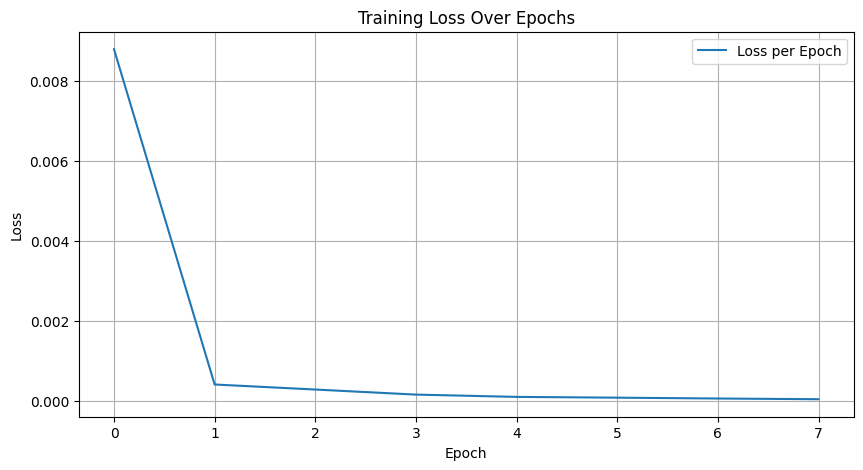

100%|██████████| 8/8 [00:57<00:00,  7.14s/it]


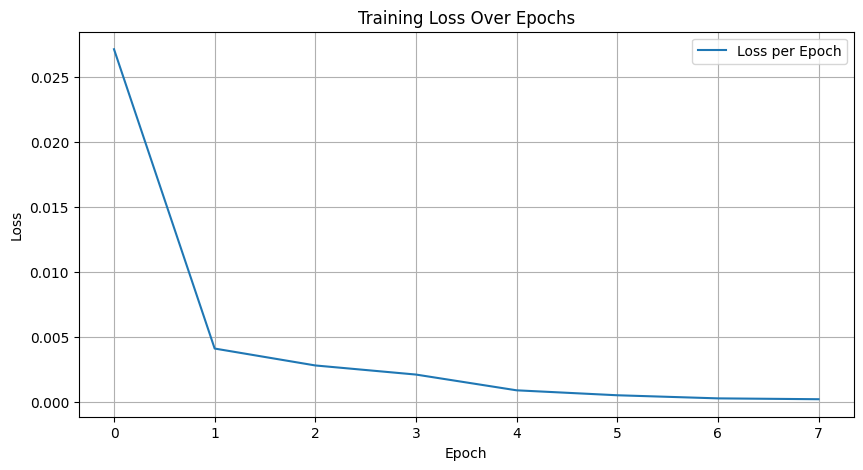

100%|██████████| 8/8 [00:57<00:00,  7.23s/it]


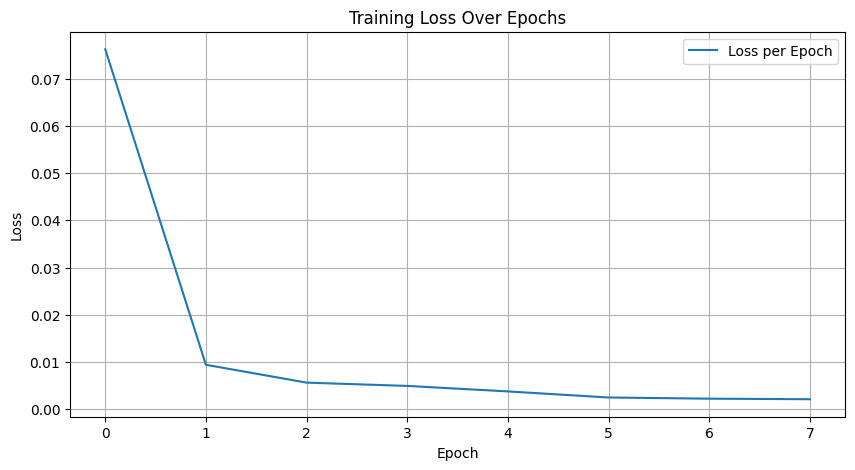

100%|██████████| 8/8 [00:58<00:00,  7.33s/it]


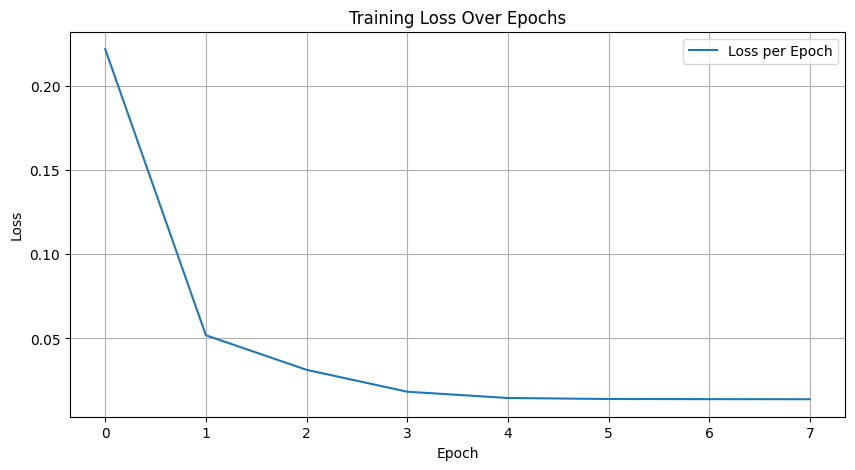

In [20]:
    layers = []
    layer1 = nn.Linear(8, 6)
    layer1_2 = nn.Linear(6, 8)
    layer2 = nn.Linear(6, 4)
    layer2_2 = nn.Linear(4, 6)
    layer3 = nn.Linear(4, 3)
    layer3_1 = nn.Linear(3, 4)
    layer4 = nn.Linear(3, 2)
    layer4_1 = nn.Linear(2, 3)
    layer5 = nn.Linear(2, 1)

    layer1 = pretrain_layer(layer1, layer1_2, previous_layer=layers, data_loader=train_loader)
    layers.append(layer1)
    layer2 = pretrain_layer(layer2, layer2_2, previous_layer=layers, data_loader=train_loader)
    layers.append(layer2)
    layer3 = pretrain_layer(layer3, layer3_1, previous_layer=layers, data_loader=train_loader)
    layers.append(layer3)
    layer4 = pretrain_layer(layer4, layer4_1, previous_layer=layers, data_loader=train_loader)
    layers.append(layer4)

In [21]:
    pretrained_model = FiveLayerNet(layer1, layer2, layer3, layer4, layer5).to(device)

In [24]:
    regular_model = FiveLayerNet(nn.Linear(8, 6), nn.Linear(6, 4), nn.Linear(4, 3), nn.Linear(3, 2), nn.Linear(2, 1)).to(device)

In [23]:
    print("Training Pretrained Model...")
    pretrained_history = train(pretrained_model, device, train_loader, epochs)

Training Pretrained Model...


  5%|▌         | 1/20 [00:07<02:22,  7.49s/it]

Epoch 1, Loss: 0.0635


 10%|█         | 2/20 [00:15<02:15,  7.55s/it]

Epoch 2, Loss: 0.0607


 15%|█▌        | 3/20 [00:22<02:08,  7.57s/it]

Epoch 3, Loss: 0.0591


 20%|██        | 4/20 [00:30<02:00,  7.52s/it]

Epoch 4, Loss: 0.0581


 25%|██▌       | 5/20 [00:37<01:51,  7.46s/it]

Epoch 5, Loss: 0.0576


 30%|███       | 6/20 [00:44<01:44,  7.43s/it]

Epoch 6, Loss: 0.0576


 35%|███▌      | 7/20 [00:52<01:38,  7.58s/it]

Epoch 7, Loss: 0.0573


 40%|████      | 8/20 [01:00<01:30,  7.55s/it]

Epoch 8, Loss: 0.0568


 45%|████▌     | 9/20 [01:07<01:22,  7.50s/it]

Epoch 9, Loss: 0.0566


 50%|█████     | 10/20 [01:15<01:14,  7.48s/it]

Epoch 10, Loss: 0.0564


 55%|█████▌    | 11/20 [01:22<01:08,  7.58s/it]

Epoch 11, Loss: 0.0564


 60%|██████    | 12/20 [01:30<01:00,  7.51s/it]

Epoch 12, Loss: 0.0562


 65%|██████▌   | 13/20 [01:37<00:52,  7.46s/it]

Epoch 13, Loss: 0.0559


 70%|███████   | 14/20 [01:44<00:44,  7.43s/it]

Epoch 14, Loss: 0.0556


 75%|███████▌  | 15/20 [01:52<00:37,  7.51s/it]

Epoch 15, Loss: 0.0556


 80%|████████  | 16/20 [02:00<00:29,  7.49s/it]

Epoch 16, Loss: 0.0553


 85%|████████▌ | 17/20 [02:07<00:22,  7.47s/it]

Epoch 17, Loss: 0.0553


 90%|█████████ | 18/20 [02:14<00:14,  7.44s/it]

Epoch 18, Loss: 0.0550


 95%|█████████▌| 19/20 [02:22<00:07,  7.40s/it]

Epoch 19, Loss: 0.0549


100%|██████████| 20/20 [02:29<00:00,  7.49s/it]

Epoch 20, Loss: 0.0545


In [25]:
    print("Training Regular Model...")
    regular_history = train(regular_model, device, train_loader, epochs)

Training Regular Model...


  5%|▌         | 1/20 [00:07<02:21,  7.47s/it]

Epoch 1, Loss: 0.0702


 10%|█         | 2/20 [00:15<02:18,  7.69s/it]

Epoch 2, Loss: 0.0597


 15%|█▌        | 3/20 [00:22<02:08,  7.57s/it]

Epoch 3, Loss: 0.0590


 20%|██        | 4/20 [00:30<01:59,  7.47s/it]

Epoch 4, Loss: 0.0585


 25%|██▌       | 5/20 [00:37<01:52,  7.47s/it]

Epoch 5, Loss: 0.0580


 30%|███       | 6/20 [00:45<01:46,  7.57s/it]

Epoch 6, Loss: 0.0579


 35%|███▌      | 7/20 [00:52<01:37,  7.51s/it]

Epoch 7, Loss: 0.0576


 40%|████      | 8/20 [01:00<01:30,  7.50s/it]

Epoch 8, Loss: 0.0572


 45%|████▌     | 9/20 [01:07<01:22,  7.46s/it]

Epoch 9, Loss: 0.0569


 50%|█████     | 10/20 [01:15<01:14,  7.50s/it]

Epoch 10, Loss: 0.0567


 55%|█████▌    | 11/20 [01:22<01:08,  7.56s/it]

Epoch 11, Loss: 0.0565


 60%|██████    | 12/20 [01:30<00:59,  7.48s/it]

Epoch 12, Loss: 0.0564


 65%|██████▌   | 13/20 [01:37<00:52,  7.43s/it]

Epoch 13, Loss: 0.0563


 70%|███████   | 14/20 [01:44<00:44,  7.40s/it]

Epoch 14, Loss: 0.0562


 75%|███████▌  | 15/20 [01:52<00:37,  7.52s/it]

Epoch 15, Loss: 0.0561


 80%|████████  | 16/20 [01:59<00:29,  7.48s/it]

Epoch 16, Loss: 0.0558


 85%|████████▌ | 17/20 [02:07<00:22,  7.45s/it]

Epoch 17, Loss: 0.0561


 90%|█████████ | 18/20 [02:14<00:14,  7.43s/it]

Epoch 18, Loss: 0.0557


 95%|█████████▌| 19/20 [02:22<00:07,  7.55s/it]

Epoch 19, Loss: 0.0557


100%|██████████| 20/20 [02:29<00:00,  7.50s/it]

Epoch 20, Loss: 0.0555


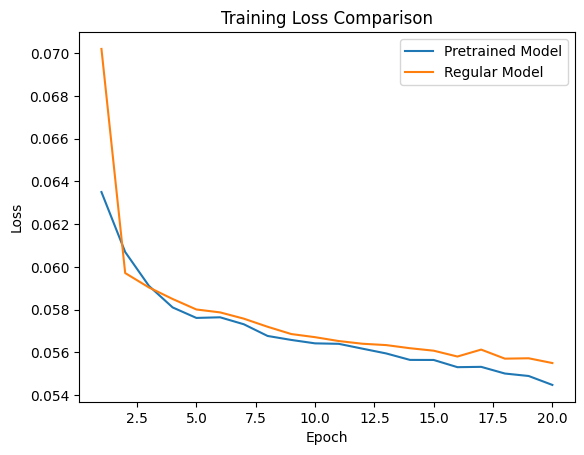

In [26]:
    plt.plot(range(1, epochs+1), pretrained_history, label='Pretrained Model')
    plt.plot(range(1, epochs+1), regular_history, label='Regular Model')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Comparison')
    plt.legend()

In [27]:
print("Pretrained_model")
test(pretrained_model, device, test_loader)
print("Reqular_model")
test(regular_model, device, test_loader)

Pretrained_model
R_SQUARED: 0.2883
MAE: 0.1926
MSE: 0.0597
RMSE: 0.2420
Reqular_model
R_SQUARED: 0.3298
MAE: 0.1873
MSE: 0.0558
RMSE: 0.2341
